In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'

import tensorflow as tf


In [2]:
EMBEDDING_FILE = 'crawl-300d-2M.vec'

train = pd.read_csv('train.csv')

X_train = train["posts"]
y_train = train[["is_T"]].values


In [3]:
max_features = 30000
maxlen = 100
embed_size = 300

In [4]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('test.csv')
X_test = test["posts"]
y_te = test["is_S"].values

In [5]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
#x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [6]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [7]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [ ]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.Precision()])

    return model

model = get_model()


In [8]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()


In [9]:
batch_size = 32
epochs = 2

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)
print(hist)
print(RocAuc)

Epoch 1/2

 ROC-AUC - epoch: 1 - score: 0.612259 

232/232 - 36s - loss: 0.4028 - accuracy: 0.8613 - val_loss: 0.3973 - val_accuracy: 0.8645
Epoch 2/2

 ROC-AUC - epoch: 2 - score: 0.671430 

232/232 - 51s - loss: 0.3480 - accuracy: 0.8646 - val_loss: 0.3792 - val_accuracy: 0.8593


In [10]:
model.fit(X_tra, y_tra, batch_size=32, epochs=2, validation_split=0.1);

Epoch 1/2
209/209 [==============================] - 31s 149ms/step - loss: 0.2496 - accuracy: 0.9010 - val_loss: 0.2137 - val_accuracy: 0.9178
Epoch 2/2
209/209 [==============================] - 30s 143ms/step - loss: 0.1241 - accuracy: 0.9558 - val_loss: 0.2382 - val_accuracy: 0.8976


In [11]:
loss, accuracy = model.evaluate(X_tra, y_tra)
loss,accuracy

232/232 [==============================] - 5s 22ms/step - loss: 0.0578 - accuracy: 0.9856


(0.05777590349316597, 0.9855737090110779)

In [12]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [13]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

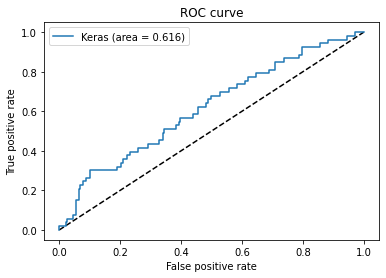

In [14]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()